Add user photo to the dataset 

In [75]:
import numpy as np
import cv2
import os
import os.path

faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)
cap.set(3,640) # set Width
cap.set(4,480) # set Height
user_name = input('\n enter user name end press <return> ==>  ')
print(os.getcwd())
directory = 'dataset/' + user_name
isExist = os.path.exists(directory)

if not isExist:
   os.makedirs(directory)
print("\n [INFO] Initializing face capture. Look the camera and wait ...")

images_in_dir_count = len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory + '/' + name))])

count = 0
while True:
    ret, img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(
        gray,     
        scaleFactor=1.2,
        minNeighbors=10,     
        minSize=(20, 20)
    )
    for (x,y,w,h) in faces:
        count += 1
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]  
        
        # Save the captured image into the datasets folder
        cv2.imwrite(directory + '/' + str(count + images_in_dir_count) + ".jpg", gray[y:y+h,x:x+w])
    cv2.imshow('video',img)
    k = cv2.waitKey(30) & 0xff 
    if k == 27: # press 'ESC' to quit
        break
    elif count >= 30: # Take 30 face sample and stop video
         break
cap.release()
cv2.destroyAllWindows()

c:\Users\Тетяна\Desktop\LNU Deep Learning

 [INFO] Initializing face capture. Look the camera and wait ...


Face recognition library

In [74]:
import face_recognition
import cv2
import numpy as np
from PIL import Image
import os
import json

dataset_path = "dataset"


recognizer = cv2.face.LBPHFaceRecognizer_create()
detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
def getImagesAndLabels(path):
    
    known_face_encodings = []
    known_face_names = [] 
    for user_folder in os.listdir(dataset_path):
        user_folder_path = os.path.join(dataset_path, user_folder)
        if os.path.isdir(user_folder_path):
            
            for image_file in os.listdir(user_folder_path):
                image_path = os.path.join(user_folder_path, image_file)

                if os.path.isfile(image_path):
                    image = face_recognition.load_image_file(image_path)

                    # Find face locations in the image
                    #face_locations = face_recognition.face_locations(image)

                    # Encode faces in the image
                    face_encoding = face_recognition.face_encodings(image)#, face_locations)

                    if face_encoding:
                        # If a face is found, add the encoding and corresponding label to the lists
                        known_face_encodings.append(face_encoding[0])
                        known_face_names.append(user_folder)
    return known_face_encodings, known_face_names
known_face_encodings, known_face_names = getImagesAndLabels(dataset_path)


In [61]:
np.array(known_face_encodings).shape

(169, 128)

In [76]:
import cv2
import numpy as np
import os 
import json

print(os.getcwd())

cascadePath = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascadePath)
font = cv2.FONT_HERSHEY_SIMPLEX
predicted_label = ""
# Initialize and start realtime video capture
cam = cv2.VideoCapture(0)
cam.set(3, 640) # set video widht
cam.set(4, 480) # set video height
# Define min window size to be recognized as a face
minW = 0.1*cam.get(3)
minH = 0.1*cam.get(4)
while True:
    ret, img =cam.read()
    #img = cv2.flip(img, -1) # Flip vertically
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    faces = faceCascade.detectMultiScale( 
        gray,
        scaleFactor = 1.2,
        minNeighbors = 10,
        minSize = (int(minW), int(minH)),
       )
    predicted_label = "Unknown"
    for(x,y,w,h) in faces:
        cv2.rectangle(img, (x,y), (x+w,y+h), (0,0,255), 2)
        gray[y:y+h,x:x+w]
        unknown_face_encoding = face_recognition.face_encodings(cv2.cvtColor(gray[y:y+h,x:x+w], cv2.COLOR_GRAY2RGB))
        if len(unknown_face_encoding) == 1:
            # Compare the unknown face encoding with the stored encodings
            matches = face_recognition.compare_faces(known_face_encodings, unknown_face_encoding[0])
            face_distances = face_recognition.face_distance(known_face_encodings, unknown_face_encoding[0])
            best_match_index = np.argmin(face_distances)
            
            if matches[best_match_index]:
                predicted_label = known_face_names[best_match_index]
                cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)
                confidence = 1 / (1 + min(face_distances))  # Using a simple transformation for similarity score
                cv2.putText(
                    img, 
                    str( "  {0}%".format(round(100 *confidence))), 
                    (x+5,y+h-5), 
                    font, 
                    1, 
                    (255,255,0), 
                    1
                   ) 

                
        
        cv2.putText(
                    img, 
                    str(predicted_label), 
                    (x+5,y-5), 
                    font, 
                    1, 
                    (255,255,255), 
                    2
                   )
     
    
    cv2.imshow('camera',img) 
    k = cv2.waitKey(10) & 0xff # Press 'ESC' for exiting video
    if k == 27:
        break
# Do a bit of cleanup
print("\n [INFO] Exiting Program and cleanup stuff")
cam.release()
cv2.destroyAllWindows()

c:\Users\Тетяна\Desktop\LNU Deep Learning

 [INFO] Exiting Program and cleanup stuff


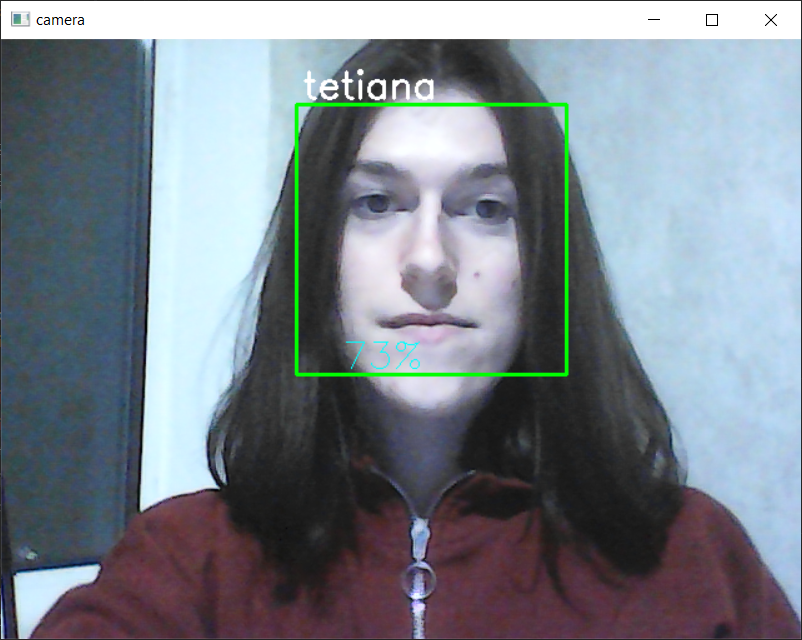

Load dataset for training a model

In [69]:
import cv2
import numpy as np
from PIL import Image
import os
import json

# Path for face image database
dataset_path = "dataset"

detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
# function to get the images and label data
def getImagesAndLabels(path):
    images = []
    user_names = []

    for user_folder in os.listdir(dataset_path):
        user_folder_path = os.path.join(dataset_path, user_folder)
        if os.path.isdir(user_folder_path):
            
            for image_file in os.listdir(user_folder_path):
                image_path = os.path.join(user_folder_path, image_file)

                if os.path.isfile(image_path):

                    PIL_img = Image.open(image_path).convert('L') # grayscale
                    img_numpy = np.array(PIL_img,'uint8')
        

                    images.append(img_numpy)
                    user_names.append(user_folder)
    return images,user_names

def labels_to_int(labels):
    
    # Заповнюємо словник імен та його обернену версію
    class_to_number = {}
    number_to_class={}
    for number, class_name in enumerate(set(labels)):
        class_to_number[class_name] = number
        number_to_class[number] = class_name
    # Зберігаємо словники у файли
    with open('class_to_number.json', 'w') as file:
        json.dump(class_to_number, file)
    with open('number_to_class.json', 'w') as file:
        json.dump(number_to_class, file)

    # Тепер можна використовувати ці словники для перетворення назв класів в числа і навпаки
    numeric_labels = [class_to_number[class_name] for class_name in labels]
    return numeric_labels

images,user_names = getImagesAndLabels(dataset_path)
numeric_classes = labels_to_int(user_names)


In [70]:
images[0]

array([[139, 138, 138, ..., 136, 145, 144],
       [140, 141, 142, ..., 132, 141, 137],
       [138, 140, 142, ..., 128, 137, 136],
       ...,
       [ 45,  40,  37, ...,  62,  63,  61],
       [ 45,  40,  37, ...,  60,  63,  63],
       [ 42,  41,  40, ...,  55,  60,  61]], dtype=uint8)

Train model

In [71]:
recognizer = cv2.face.LBPHFaceRecognizer_create()

print ("\n [INFO] Training faces. It will take a few seconds. Wait ...")
data = np.array( images)
recognizer.train(data, np.array(numeric_classes))##################################
# Save the model into trainer/trainer.yml
recognizer.write('trainer/trainer.yml') 

# Print the numer of faces trained and end program
print("\n [INFO] {0} faces trained. Exiting Program".format(len(np.unique(user_names))))


 [INFO] Training faces. It will take a few seconds. Wait ...


C:\Users\Тетяна\AppData\Local\Temp\ipykernel_8756\3934041729.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array( images)



 [INFO] 3 faces trained. Exiting Program


Test with trained model

In [72]:
import cv2
import numpy as np
import os 
import json

print(os.getcwd())
recognizer = cv2.face.LBPHFaceRecognizer_create()######################
recognizer.read('trainer/trainer.yml')#####################
with open('number_to_class.json', 'r') as file:
    loaded_number_to_class = json.load(file)
loaded_number_to_class = {int(key): value for key, value in loaded_number_to_class.items()}
id = 0###############################

cascadePath = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascadePath)
font = cv2.FONT_HERSHEY_SIMPLEX

# Initialize and start realtime video capture
cam = cv2.VideoCapture(0)
cam.set(3, 640) # set video widht
cam.set(4, 480) # set video height
# Define min window size to be recognized as a face
minW = 0.1*cam.get(3)
minH = 0.1*cam.get(4)
while True:
    ret, img =cam.read()
    #img = cv2.flip(img, -1) # Flip vertically
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    faces = faceCascade.detectMultiScale( 
        gray,
        scaleFactor = 1.2,
        minNeighbors = 10,
        minSize = (int(minW), int(minH)),
       )
    for(x,y,w,h) in faces:
        cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)
        id, confidence = recognizer.predict(gray[y:y+h,x:x+w])#################
        
        # If confidence is less them 100 ==> "0" : perfect match 
        if (confidence < 100):
            id = loaded_number_to_class[id]
            confidence = "  {0}%".format(round(100 - confidence))
        else:
            id = "unknown"
            confidence = "  {0}%".format(round(100 - confidence))
        
        cv2.putText(
                    img, 
                    str(id), 
                    (x+5,y-5), 
                    font, 
                    1, 
                    (255,255,255), 
                    2
                   )
        cv2.putText(
                    img, 
                    str(confidence), 
                    (x+5,y+h-5), 
                    font, 
                    1, 
                    (255,255,0), 
                    1
                   )  
    
    cv2.imshow('camera',img) 
    k = cv2.waitKey(10) & 0xff # Press 'ESC' for exiting video
    if k == 27:
        break
# Do a bit of cleanup
print("\n [INFO] Exiting Program and cleanup stuff")
cam.release()
cv2.destroyAllWindows()

c:\Users\Тетяна\Desktop\LNU Deep Learning

 [INFO] Exiting Program and cleanup stuff


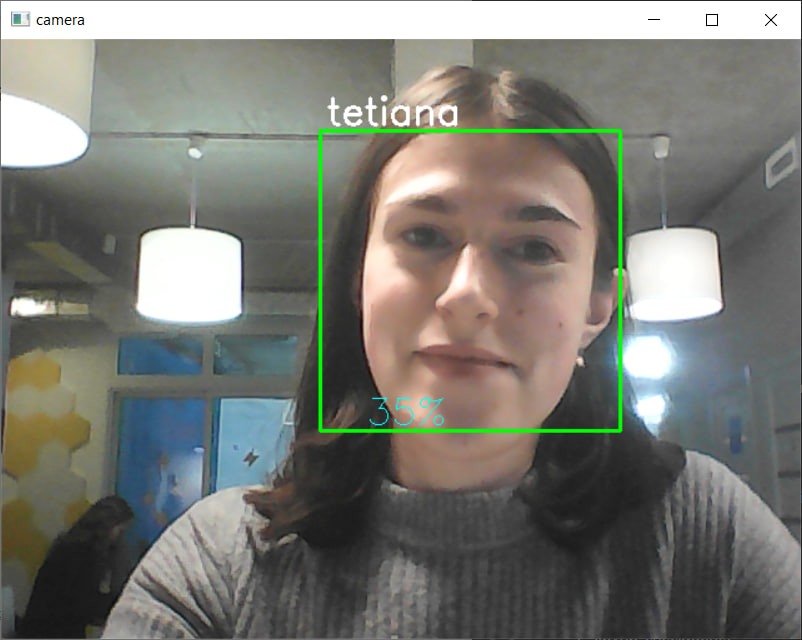